# YOLO v1 

# Setup

In [3]:
import os
import sys
import json
import pathlib
from typing import (
    List,
    Dict,
    Tuple
)

import numpy as np
import tensorflow as tf
from tensorflow import keras   # MUST to make sure of using tensorflow.keras, not keras
from tensorflow.keras import (
    backend as K
)
from tensorflow.keras.models import (
    Model,
)
from tensorflow.keras.layers import (
    Layer,
    Normalization,
)
import tensorflow_datasets as tfds

In [4]:
# tf.config.run_functions_eagerly(False)
# tf.data.experimental.enable_debug_mode()

## PYTHONPATH

In [5]:
path_to_lib: str = str(pathlib.Path(os.path.join(os.getcwd(), "../../..")).resolve())
assert isinstance(path_to_lib, str)
sys.path.append(path_to_lib)

In [6]:
%load_ext autoreload
%autoreload 2

from util_file import (
    mkdir
)
from util_datetime import (
    get_datetime_string
)
from util_opencv.image import (
    get_image,
    show_image,
)
from util_tf.nn import (
    train,
    get_early_stopping_callback,
    get_tensorboard_callback,
)
from util_tf.tfds.voc import (
    generate_yolo_v1_labels_from_pascal_voc,
    generate_yolo_v1_data_from_pascal_voc,
    PASCAL_VOC_CLASSES,
)

from constant import (
    DEBUG_LEVEL,
    TYPE_FLOAT,
    YOLO_V1_PREDICTION_NUM_CLASSES,
    YOLO_GRID_SIZE,
    YOLO_V1_IMAGE_WIDTH,
    YOLO_V1_IMAGE_HEIGHT,
    YOLO_V1_LABEL_LENGTH,
    YOLO_V1_LABEL_INDEX_CP,
    YOLO_V1_LABEL_INDEX_X,
    YOLO_V1_LABEL_INDEX_Y,
    YOLO_V1_LABEL_INDEX_W,
    YOLO_V1_LABEL_INDEX_H,
    YOLO_V1_PREDICTION_NUM_PRED,
    YOLO_V1_PREDICTION_NUM_CLASSES,
    YOLO_V1_LR_1ST,
    YOLO_V1_EPOCHS_1ST,
    YOLO_V1_LR_2ND,
    YOLO_V1_EPOCHS_2ND,
    YOLO_V1_LR_3RD,
    YOLO_V1_EPOCHS_3RD,
    YOLO_V1_LR_4TH,
    YOLO_V1_EPOCHS_4TH,
)
from model import (
    layers_config,
    input_shape,
    YOLOModel,
)

# Constant

In [7]:
S = YOLO_GRID_SIZE
C = YOLO_V1_PREDICTION_NUM_CLASSES
P = YOLO_V1_PREDICTION_NUM_PRED

In [8]:
TFDS_DATA_DIR = "/Volumes/SSD/data/tfds/"
TF_LOG_DIR = "/Volumes/SSD/data/log/"

---
# Data

## TFDS PASCAL VOC

In [59]:
voc, info = tfds.load(
    name='voc', 
    data_dir=TFDS_DATA_DIR,
    with_info=True,
)
info

tfds.core.DatasetInfo(
    name='voc',
    full_name='voc/2007/4.0.0',
    description="""
    This dataset contains the data from the PASCAL Visual Object Classes Challenge,
    corresponding to the Classification and Detection competitions.
    
    In the Classification competition, the goal is to predict the set of labels
    contained in the image, while in the Detection competition the goal is to
    predict the bounding box and label of each individual object.
    annotations.
    """,
    config_description="""
    This dataset contains the data from the PASCAL Visual Object Classes Challenge
    2007, a.k.a. VOC2007.
    
    A total of 9963 images are included in this dataset, where each image
    contains a set of objects, out of 20 different classes, making a total of
    24640 annotated objects.
    
    """,
    homepage='http://host.robots.ox.ac.uk/pascal/VOC/voc2007/',
    data_path='/Volumes/SSD/data/tfds/voc/2007/4.0.0',
    file_format=tfrecord,
    download_size=868

## YOLO v1 dataset

Dataset in ```(input,label)``` format where input is ```(448,448,3)``` RGB image and label is YOLO v1 label in ```(C,P)``` format where ```P=(cp,x,y,w,h)```.

In [60]:
# tf.config.run_functions_eagerly(True)
# tf.data.experimental.enable_debug_mode()
train = voc['train'].map(generate_yolo_v1_data_from_pascal_voc)
validation = voc['validation'].map(generate_yolo_v1_data_from_pascal_voc)

### Input Image

(448, 448, 3)


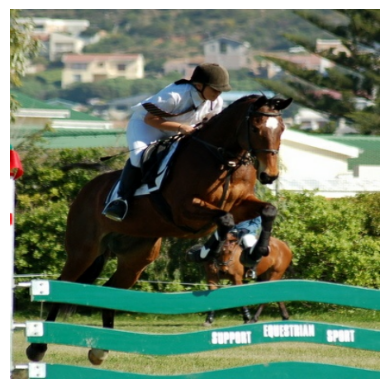

In [61]:
record = next(train.as_numpy_iterator())
image = record[0]
label = record[1]

print(image.shape)
show_image(image=image.astype(np.uint8), bgr_to_rgb=False)

### Label

In [62]:
for id, cell in enumerate(label.reshape((-1, C+P))):
    cp = cell[YOLO_V1_LABEL_INDEX_CP]
    if cp == 1:
        classes = cell[:YOLO_V1_PREDICTION_NUM_CLASSES]
        print("cell:({},{}) is {}".format(
            int(id / S), 
            int(id % S), 
            PASCAL_VOC_CLASSES[np.argmax(cell[:YOLO_V1_PREDICTION_NUM_CLASSES]==1)]
        ))


cell:(2,2) is person
cell:(3,2) is horse
cell:(4,4) is person
cell:(5,4) is horse


In [63]:
def validate(image, label):
    tf.debugging.assert_all_finite(x=image, message="expected record is finite")
    tf.debugging.assert_all_finite(x=label, message="expected record is finite")

    return 1

In [23]:
_ = train.map(validate)
del _

_ = validation.map(validate)
del _

---

# Model

<img src="./image/architecture.png" align="left"/>


* yolo.cfg

```
[net]
batch=64
subdivisions=64
height=448
width=448
channels=3
momentum=0.9
decay=0.0005

learning_rate=0.001
policy=steps
steps=200,400,600,20000,30000
scales=2.5,2,2,.1,.1
max_batches = 40000

[crop]
crop_width=448
crop_height=448
flip=0
angle=0
saturation = 1.5
exposure = 1.5

[convolutional]
filters=64
size=7
stride=2
pad=1
activation=leaky

[maxpool]
size=2
stride=2

[convolutional]
filters=192
size=3
stride=1
pad=1
activation=leaky

[maxpool]
size=2
stride=2

[convolutional]
filters=128
size=1
stride=1
pad=1
activation=leaky

[convolutional]
filters=256
size=3
stride=1
pad=1
activation=leaky

[convolutional]
filters=256
size=1
stride=1
pad=1
activation=leaky

[convolutional]
filters=512
size=3
stride=1
pad=1
activation=leaky

[maxpool]
size=2
stride=2

[convolutional]
filters=256
size=1
stride=1
pad=1
activation=leaky

[convolutional]
filters=512
size=3
stride=1
pad=1
activation=leaky

[convolutional]
filters=256
size=1
stride=1
pad=1
activation=leaky

[convolutional]
filters=512
size=3
stride=1
pad=1
activation=leaky

[convolutional]
filters=256
size=1
stride=1
pad=1
activation=leaky

[convolutional]
filters=512
size=3
stride=1
pad=1
activation=leaky

[convolutional]
filters=256
size=1
stride=1
pad=1
activation=leaky

[convolutional]
filters=512
size=3
stride=1
pad=1
activation=leaky

[convolutional]
filters=512
size=1
stride=1
pad=1
activation=leaky

[convolutional]
filters=1024
size=3
stride=1
pad=1
activation=leaky

[maxpool]
size=2
stride=2

[convolutional]
filters=512
size=1
stride=1
pad=1
activation=leaky

[convolutional]
filters=1024
size=3
stride=1
pad=1
activation=leaky

[convolutional]
filters=512
size=1
stride=1
pad=1
activation=leaky

[convolutional]
filters=1024
size=3
stride=1
pad=1
activation=leaky

#######

[convolutional]
size=3
stride=1
pad=1
filters=1024
activation=leaky

[convolutional]
size=3
stride=2
pad=1
filters=1024
activation=leaky

[convolutional]
size=3
stride=1
pad=1
filters=1024
activation=leaky

[convolutional]
size=3
stride=1
pad=1
filters=1024
activation=leaky

[connected]
output=4096
activation=leaky

[dropout]
probability=.5

[connected]
output= 1470
activation=linear

[detection]
classes=20
coords=4
rescore=1
side=7
num=2
softmax=0
sqrt=1
jitter=.2

object_scale=1
noobject_scale=.5
class_scale=1
coord_scale=5
```

In [24]:
input_shape

(448, 448, 3)

In [89]:
model: Model = YOLOModel()

Model: "yolo_v1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 448, 448, 3)]     0         
                                                                 
 norm (Normalization)        (None, 448, 448, 3)       7         
                                                                 
 conv01 (Conv2D)             (None, 224, 224, 64)      9472      
                                                                 
 act01 (LeakyReLU)           (None, 224, 224, 64)      0         
                                                                 
 maxpool01 (MaxPooling2D)    (None, 112, 112, 64)      0         
                                                                 
 conv02 (Conv2D)             (None, 112, 112, 192)     110784    
                                                                 
 act02 (LeakyReLU)           (None, 112, 112, 192)     0   

---
# Normalize

The model includes a Normalization layer as the first layer. Fit the layer to the sample data. No need to use entire data to fit but adequate samples will suffice. Hence use ```shard(num_shard=10)``` to only use 1/10 of the data.

In [66]:
norm: Layer = model.get_layer(name="norm")
for weight in norm.weights:
    print(weight.name, weight.numpy())

norm/mean:0 [0. 0. 0.]
norm/variance:0 [1. 1. 1.]
norm/count:0 0


In [67]:
norm.axis   # standardize along axis=-1 (depth wise standardization where each pixel is a feature)

(-1,)

In [79]:
def extract_input(image, label):
    """Take input image from (input, label) data"""
    return image

def extract_label(image, label):
    """Take label from (input, label) data"""
    return label

In [69]:
samples = train\
    .shuffle(buffer_size=128)\
    .prefetch(buffer_size=tf.data.AUTOTUNE)\
    .shard(num_shards=10, index=0)\
    .shuffle(buffer_size=128)\
    .map(extract_input)

In [70]:
norm.adapt(samples)

## Verification

### Normalization Layer Weights

Make sure the normalization layer has been adapted.

In [71]:
for weight in norm.weights:
    print(weight.name, weight.numpy())

norm/mean:0 [105.16504 105.16504 105.16504]
norm/variance:0 [4935.464 4935.464 4935.464]
norm/count:0 151130112


### Staandization and Restoration

Make sure the Normalization layer standardize the image that can be restored via $x = standardized(x) * std(x) + \hat{x}$.

(448, 448, 3)


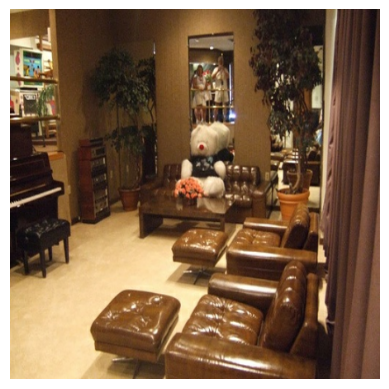

In [72]:
image = next(samples.take(1).as_numpy_iterator())
print(image.shape)
show_image(image=image.astype(np.uint8), bgr_to_rgb=False)

In [73]:
norm(image).numpy().mean()

-0.26322293

In [74]:
norm(image).shape

TensorShape([1, 448, 448, 3])

In [75]:
model.get_layer(name="norm")(image).numpy().mean()

-0.26322293

Verify restored image via $x = standardized(x) * std(x) + \hat{x}$ .

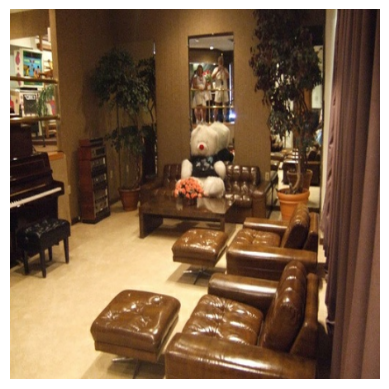

In [76]:
restored = norm(image).numpy().squeeze() * np.sqrt(norm.variance.numpy().squeeze()) + norm.mean.numpy().squeeze()
show_image(image=restored.astype(np.uint8), bgr_to_rgb=False)

In [77]:
del samples

---
# Model Validation

Make sure the model output is **NOT nan nor inf**.

In [90]:
pos = 0
for image in train.map(extract_input).as_numpy_iterator():
    output = model.model(image.reshape(-1, 448, 448, 3))
    if pos % 1000 == 0:
        print(pos)
        
    if not np.all(np.isfinite(output.numpy())):
        print(pos)
        print(output)
    
    tf.debugging.assert_all_finite(x=output, message="expected finite")
    pos += 1
    
print(pos)

KeyboardInterrupt: 

---
# Training

### Tensorboard callback

In [91]:
log_dir = os.path.join(TF_LOG_DIR, "yolo/v1", get_datetime_string())
mkdir(log_dir)

In [92]:
tensorboard_callback = get_tensorboard_callback(
    log_dir=log_dir,
    write_graph=True,
    write_images=True,
    histogram_freq=1,  # How often to log histogram visualizations
    embeddings_freq=1  # How often to log embedding visualizations
)

### Early stop callback

In [93]:
earlystop_callback = get_early_stopping_callback(
    monitor='val_loss', 
    mode='min',
    patience=10,
    verbose=1,
    restore_best_weights=True,
)

## Run

> We train the network for about 135 epochs on the training and validation data sets
from PASCAL VOC 2007 and 2012. When testing on 2012 we also include the VOC 2007
test data for training.
> 
> Throughout training, we use a batch size of 64, a momentum of 0:9 and a decay of 0:0005.
> 
> Our learning rate schedule is as follows: For the first epochs we slowly raise the
learning rate from 10^-3 (1e-3) to 10^-2 (1e-2). If we start at a high learning rate
our model often diverges due to unstable gradients. We continue training with 10^-2
for 75 epochs, then 10^-3 for 30 epochs, and finally 10^4 (1e-4) for 30 epochs.


In [94]:
BATCH_SIZE = 32
VERBOSE = 1
# Used for generator or keras.utils.Sequence input only
USE_MULTIPROCESSING = None
WORKERS = None

In [95]:
train = train.shuffle(
    buffer_size=1024
).batch(
    batch_size=BATCH_SIZE,
    num_parallel_calls=tf.data.AUTOTUNE,
    drop_remainder=True
).prefetch(
    buffer_size=1
)

In [96]:
validation = validation.shuffle(
    buffer_size=1024
).batch(
    batch_size=BATCH_SIZE,
    num_parallel_calls=tf.data.AUTOTUNE,
    drop_remainder=True
).prefetch(
    buffer_size=1
)

### Initial 10 epochs with LR=1e-3

In [ ]:
print(f"learning rate: {model.learning_rate}")

history = model.model.fit(
    x=train,
    shuffle=True,
    epochs=YOLO_V1_EPOCHS_1ST,
    validation_data=validation,
    use_multiprocessing=USE_MULTIPROCESSING,
    workers=WORKERS,
    verbose=VERBOSE,
    callbacks=[
        tensorboard_callback,
        earlystop_callback
    ]
)

learning rate: 0.0010000000474974513
Epoch 1/10


2023-03-17 20:51:12.523169: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: YOLOLoss/assert_non_negative/assert_less_equal/Assert/AssertGuard/branch_executed/_8


x_y_loss 8.60445786
w_h_loss 8.96165466
confidence_loss 2.73674631
no_obj_confidence_loss 0.000520101399
classification_loss 2.74252796
loss 23.0459061


### 75 epochs with LR=1e-2

In [ ]:
model.learning_rate(YOLO_V1_LR_2ND)
print(f"learning rate: {model.learning_rate}")

history = model.fit(
    x=X_train,
    y=y_train,
    shuffle=True,
    validation_data=(X_validation, y_validation),
    initial_epoch=YOLO_V1_EPOCHS_1ST,
    epochs=YOLO_V1_EPOCHS_2ND,
    use_multiprocessing=USE_MULTIPROCESSING,
    workers=WORKERS,
    verbose=VERBOSE,
    callbacks=[
        tensorboard_callback,
        earlystop_callback
    ]
)

### 30 epochs with LR=1e-3

In [ ]:
model.learning_rate(YOLO_V1_LR_3RD)
print(f"learning rate: {model.learning_rate}")

history = model.fit(
    x=X_train,
    y=y_train,
    shuffle=True,
    initial_epoch=YOLO_V1_EPOCHS_1ST+YOLO_V1_EPOCHS_2ND,
    epochs=YOLO_V1_EPOCHS_3RD,
    validation_data=(X_validation, y_validation),
    use_multiprocessing=USE_MULTIPROCESSING,
    workers=WORKERS,
    verbose=VERBOSE,
    callbacks=[
        tensorboard_callback,
        earlystop_callback
    ]
)

### 30 epochs with LR=1e=4

In [ ]:
model.learning_rate(YOLO_V1_LR_4TH)
print(f"learning rate: {model.learning_rate}")

history = model.fit(
    x=X_train,
    y=y_train,
    shuffle=True,
    initial_epoch=YOLO_V1_EPOCHS_1ST+YOLO_V1_EPOCHS_2ND+YOLO_V1_EPOCHS_3RD,
    epochs=YOLO_V1_EPOCHS_4TH,
    validation_data=(X_validation, y_validation),
    use_multiprocessing=USE_MULTIPROCESSING,
    workers=WORKERS,
    verbose=VERBOSE,
    callbacks=[
        tensorboard_callback,
        earlystop_callback
    ]
)